In [13]:
import json
from pathlib import Path
import numpy as np
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt


import pandas as pd
from gears import PertData

In [2]:
FEATURE_NAME_MAP = {
        "go": "go",
        "elmo": "scElmo",
        "foundation": "scFoundation",
        "gpt": "scGPT",
    }

def load_bulk_model_resutlts( dataset: str, _res_dir: Path = Path("./save")):
    
    res_dict = {}
    for model in ["RF", "EN", "KNN"]:
        for feature in ["go", "elmo", "foundation", "gpt"]:
            with open(_res_dir / dataset / model / feature / "test_metrics.json") as f:
                res_dict[f"{model}_{FEATURE_NAME_MAP[feature]}"] = json.load(f)
    with open(_res_dir / dataset / "mean" / "test_metrics.json") as f:
        res_dict["mean"] = json.load(f)

    return res_dict


def calc_de_metric(_pert_data: PertData, _dir_map: dict, _df_de: pd.DataFrame):
    data = _pert_data.adata.to_df()
    data['condition'] = _pert_data.adata.obs['condition']
    data = data.groupby('condition').mean()

    ctrl_mean = data.loc['ctrl'].values

    for _name, _dir in _dir_map.items():
        test_res = np.load(_dir / "test_res_best_model.npz", allow_pickle=True)
        # test_pred = pd.read_csv(_dir / "predictions.csv", index_col=0)
        test_pred = pd.DataFrame(test_res["pred"], columns=data.columns, index=test_res["pert_cat"])

        test_truth = pd.DataFrame(test_res["truth"], columns=test_pred.columns, index=test_pred.index)

        # only keep test data
        _df_de = _df_de.loc[test_truth.index].copy()

        res = []
        for cond, de_genes in _df_de.iterrows():
            true = test_truth.loc[cond] - ctrl_mean
            pred = test_pred.loc[cond]- ctrl_mean

            res.append(pearsonr(true[de_genes], pred[de_genes])[0])
    
    return np.mean(res)

def gather_results(
        de_df: pd.DataFrame,
        pert_data: PertData,
        bulk_model_dir: Path,
        sc_model_dir_map: dict[str, Path],
        ):


    models = ["RF", "EN", "KNN"]
    features = ["go", "elmo", "foundation", "gpt"]

    res = []

    for model in models:
        for feature in features:
            _dir = Path(bulk_model_dir / f"{model}/{feature}")
            _exp_name = f"{model}_{feature}"
            out = calc_de_metric(pert_data, {_exp_name: _dir}, de_df)

            _exp_name = f"{model}_{FEATURE_NAME_MAP[feature]}"

            res.append({"model": _exp_name, "pearson_de_delta_alternative": out})

    # mean model
    _dir = Path(bulk_model_dir / "mean")
    out = calc_de_metric(pert_data, {"mean": _dir}, de_df)
    res.append({"model": "mean", "pearson_de_delta_alternative": out}) 

    for sc_model, _dir in sc_model_dir_map.items():
        out = calc_de_metric(pert_data, {sc_model: _dir}, de_df)
        res.append({"model": sc_model, "pearson_de_delta_alternative": out})

    res = pd.DataFrame(res)

    return res


In [3]:
# load scgpt results
with open("./save/dev_perturb_adamson-Sep26-20-36/test_metrics.json") as f:
    adamson_scgpt = json.load(f)

with open("./save/dev_perturb_norman-Sep24-13-29/test_metrics.json") as f:
    norman_scpt = json.load(f)

with open("./save/dev_perturb_replogle-Sep24-15-06/test_metrics.json") as f:
    replogle_scgpt = json.load(f)

with open("./save/dev_perturb_replogle_rpe1-Feb25-16-55/test_metrics.json") as f:
    replogle_rpe1_scgpt = json.load(f)

# load scfoundation results
sc_foundation_base = Path("../scFoundation/GEARS/results/")
with open(sc_foundation_base / "adamson/0.75/baseline_simulation_seed_1_hidden_512_epochs_10_batch_32_accmu_1_mode_v1_highres_0_lr_0.0005/2025-02-12_10-47-01/test_metrics.json") as f:
    adamson_scfoundation = json.load(f)

with open(sc_foundation_base / "norman/0.75/baseline_simulation_seed_1_hidden_512_epochs_10_batch_32_accmu_1_mode_v1_highres_0_lr_0.01/2025-02-12_00-47-27/test_metrics.json") as f:
    norman_scfoundation = json.load(f)

with open(sc_foundation_base / "replogle_k562_essential/0.75/baseline_simulation_seed_1_hidden_512_epochs_10_batch_16_accmu_2_mode_v1_highres_0_lr_0.01/2025-02-17_16-45-12/test_metrics.json") as f:
    replogle_scfoundation = json.load(f) 

with open(sc_foundation_base / "replogle_rpe1_essential_raw/0.75/baseline_simulation_seed_1_hidden_512_epochs_10_batch_16_accmu_2_mode_v1_highres_0_lr_0.01/2025-02-26_07-59-12/test_metrics.json") as f:
    replogle_rp1 = json.load(f) 

In [4]:
adamson_results = load_bulk_model_resutlts("adamson")
adamson_results["scGPT"] = adamson_scgpt
adamson_results["scFoundation"] = adamson_scfoundation

norman_results = load_bulk_model_resutlts("norman")
norman_results["scGPT"] = norman_scpt
norman_results["scFoundation"] = norman_scfoundation

replogle_results = load_bulk_model_resutlts("replogle")
replogle_results["scGPT"] = replogle_scgpt
replogle_results["scFoundation"] = replogle_scfoundation

replogle_rp1_results = load_bulk_model_resutlts("replogle_rpe1")
replogle_rp1_results["scGPT"] = replogle_rpe1_scgpt
replogle_rp1_results["scFoundation"] = replogle_rp1

adamson_results = (pd.DataFrame.from_dict(adamson_results, orient='index').reset_index().rename(columns={"index": "model"}))
norman_results = pd.DataFrame.from_dict(norman_results, orient='index').reset_index().rename(columns={"index": "model"})
replogle_results = pd.DataFrame.from_dict(replogle_results, orient='index').reset_index().rename(columns={"index": "model"})
replogle_rp1_results = pd.DataFrame.from_dict(replogle_rp1_results, orient='index').reset_index().rename(columns={"index": "model"})

## Alternative DE20 eval

In [5]:
DE_ANALYSIS_DIR = Path("../data/DE_anal/")

adamson_de = pd.read_csv(DE_ANALYSIS_DIR / "adamson_DE.csv", index_col=0).T
norman_de = pd.read_csv(DE_ANALYSIS_DIR / "norman_DE.csv", index_col=0).T
replogle_de = pd.read_csv(DE_ANALYSIS_DIR / "replogle_DE.csv", index_col=0).T
replogle_rp1_de = pd.read_csv(DE_ANALYSIS_DIR / "replogle_rpe_DE.csv", index_col=0).T

### Adamson

In [6]:
pert_data_adamson = PertData("../data/")
pert_data_adamson.load(data_name='adamson')
pert_data_adamson.prepare_split(split="simulation", seed=1)

Found local copy...
Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:0
combo_seen1:0
combo_seen2:0
unseen_single:22
Done!


In [7]:
adamson_res_new = gather_results(
    de_df=adamson_de,
    pert_data=pert_data_adamson,
    bulk_model_dir=Path("./save/adamson"),
    sc_model_dir_map={
        "scGPT": Path("./save/dev_perturb_adamson-Sep26-20-36"),
        "scFoundation": Path(sc_foundation_base / "adamson/0.75/baseline_simulation_seed_1_hidden_512_epochs_10_batch_32_accmu_1_mode_v1_highres_0_lr_0.0005/2025-02-12_10-47-01"),
    }    
)

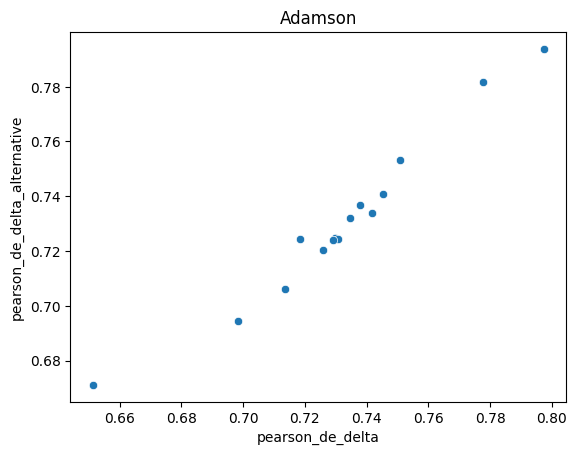

In [24]:
adamson_res_new = adamson_res_new.merge(adamson_results[["model", "pearson_de_delta"]], on="model")
sns.scatterplot(data=adamson_res_new, x="pearson_de_delta", y="pearson_de_delta_alternative")
plt.title("Adamson")
plt.show()

## Norman

In [15]:
pert_data_norman = PertData("../data/")
pert_data_norman.load(data_path='../data/norman/')
pert_data_norman.prepare_split(split="simulation", seed=1)

Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:9
combo_seen1:52
combo_seen2:18
unseen_single:37
Done!


In [16]:
norman_res_new = gather_results(
    de_df=norman_de,
    pert_data=pert_data_norman,
    bulk_model_dir=Path("./save/norman"),
    sc_model_dir_map={
        "scgpt": Path("./save/dev_perturb_norman-Sep24-13-29"),
        "scfoundation": Path(sc_foundation_base / "norman/0.75/baseline_simulation_seed_1_hidden_512_epochs_10_batch_32_accmu_1_mode_v1_highres_0_lr_0.01/2025-02-12_00-47-27"),
    }    
)

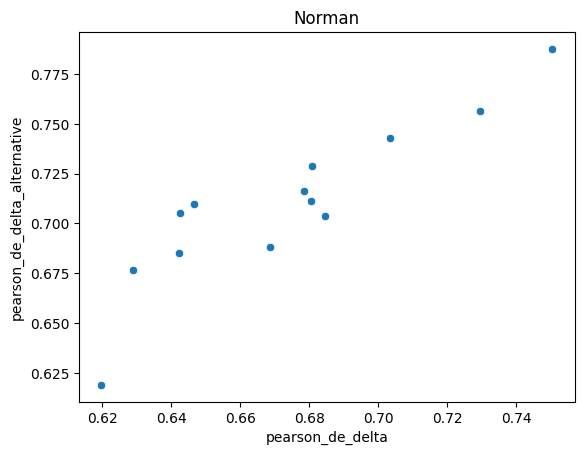

In [18]:
norman_res_new = norman_res_new.merge(norman_results[["model", "pearson_de_delta"]], on="model")

sns.scatterplot(data=norman_res_new, x="pearson_de_delta", y="pearson_de_delta_alternative")
plt.title("Norman")
plt.show()

## Replogle

In [19]:
pert_data_replogle = PertData("../data/")
pert_data_replogle.load(data_path='../data/replogle_k562_essential/')
pert_data_replogle.prepare_split(split="simulation", seed=1)

Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:0
combo_seen1:0
combo_seen2:0
unseen_single:273
Done!


In [ ]:
replogle_res_new = gather_results(
    de_df=replogle_de,
    pert_data=pert_data_replogle,
    bulk_model_dir=Path("./save/replogle"),
    sc_model_dir_map={
        "scgpt": Path("./save/dev_perturb_replogle-Sep24-15-06"),
        "scfoundation": Path(sc_foundation_base / "replogle_k562_essential/0.75/baseline_simulation_seed_1_hidden_512_epochs_10_batch_16_accmu_2_mode_v1_highres_0_lr_0.01/2025-02-17_16-45-12"),
    }    
)

In [ ]:
replogle_res_new = replogle_res_new.merge(replogle_results[["model", "pearson_de_delta"]], on="model")

sns.scatterplot(data=replogle_res_new, x="pearson_de_delta", y="pearson_de_delta_alternative")
plt.title("Replogle")
plt.show()


## Replogle RPE1

In [21]:
pert_data_replogle_rpe = PertData("../data/")
pert_data_replogle_rpe.load(data_path='../data/replogle_rpe1_essential/')
pert_data_replogle_rpe.prepare_split(split="simulation", seed=1)

Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:0
combo_seen1:0
combo_seen2:0
unseen_single:386
Done!


In [22]:
replogle_rp1_res_new = gather_results(
    de_df=replogle_rp1_de,
    pert_data=pert_data_replogle_rpe,
    bulk_model_dir=Path("./save/replogle_rpe1"),
    sc_model_dir_map={
        "scgpt": Path("./save/dev_perturb_replogle_rpe1-Feb25-16-55"),
        "scfoundation": Path(sc_foundation_base / "replogle_rpe1_essential_raw/0.75/baseline_simulation_seed_1_hidden_512_epochs_10_batch_16_accmu_2_mode_v1_highres_0_lr_0.01/2025-02-26_07-59-12"),
    }    
)

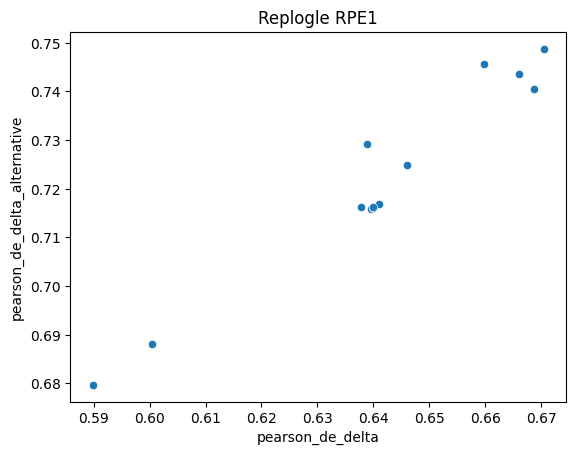

In [23]:
replogle_rp1_res_new = replogle_rp1_res_new.merge(replogle_rp1_results[["model", "pearson_de_delta"]], on="model")

sns.scatterplot(data=replogle_rp1_res_new, x="pearson_de_delta", y="pearson_de_delta_alternative")
plt.title("Replogle RPE1")
plt.show()